In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad
import numpy as np

In [160]:
df = pd.read_csv('dados_avc.csv')
df.head(2)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [161]:
# Preencher valores ausentes em 'bmi' com a média
df['bmi'].replace('N/A', float('nan'), inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
# Criar faixas etárias
age_bins = [0, 18, 35, 60, 100]
age_labels = ['Criança/Adolescente', 'Jovem', 'Adulto', 'Idoso']
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Criar categorias de IMC
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ['Abaixo do peso', 'Peso normal', 'Sobrepeso', 'Obesidade']
df['bmi'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# Criar níveis de glicose no sangue
glucose_bins = [0, 70, 130, 200, 900]
glucose_labels = ['Baixo', 'Normal', "Alto", 'Muito alto']
df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

# Converter colunas categóricas usando one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','avg_glucose_level', 'bmi', 'age'], drop_first=True)
df.head(15)


,id,hypertension,heart_disease,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,9046,0,1,1,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
1,51676,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,1
2,31112,0,1,1,1,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1
3,60182,0,0,1,0,0,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0
4,1665,1,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
5,56669,0,0,1,1,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
6,53882,1,1,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
7,10434,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
8,27419,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
9,60491,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [162]:
X = df.drop(['stroke', 'id'], axis=1)
Y = df['stroke']


In [163]:
X.head(1)

,hypertension,heart_disease,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,0,1,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1


In [164]:
## converting the 0 to -1
X = X.replace(0, -1)

## convering the True to 1 and False to -1
Y = Y.replace(0, -1)
X = X.replace(True, 1)
X = X.replace(False, -1)

X = X.astype('float64')
Y = Y.astype('float64')

In [165]:
X = X[:500]
Y = Y[:500]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)


In [166]:
# print(Y_train.value_counts())

In [167]:
# print(dict(np.unique(Y_train, return_counts=True)))
# print(dict(np.unique(Y_train, return_counts=True)))

In [168]:
def loss( parametros ):
    w, b, x, y = parametros
    est = w.T @ x + b
    mse = np_.mean( (est - y)**2)
    return mse

g = grad(loss)
x = np.array(X_train).T
y = np.array(Y_train)


In [169]:
w = np.random.randn(x.shape[0], 1)
b = 0.0
alpha = 10**-2

for n in range(15000):
    grad_ = g( (w, b, x, y) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]


In [170]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred[Y_pred > 0] = 1
Y_pred[Y_pred <= 0] = -1

In [171]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

## create tuples with value of w and X column name
w_tuples = []
w_lin_model = []
for i in range(len(w)):
    w_tuples.append((w[i][0], X.columns[i]))
    w_lin_model.append((model.coef_[i], X.columns[i]))

## sort the tuples
w_tuples.sort(reverse=True)
w_lin_model.sort(reverse=True)


In [172]:
print(w_tuples)

x = np.array(X_test).T
y = np.array(Y_test)

y_est = w.T @ x + b
print(f"Acurácia do modelo: {accuracy(y, y_est) * 100:.2f}%")

print(w_lin_model)

print(accuracy_score(Y_test, Y_pred))

[(2.5131592385799353, 'gender_Other'), (0.5074410875637517, 'age_Idoso'), (0.25370320491248427, 'age_Adulto'), (0.18410147340205396, 'smoking_status_formerly smoked'), (0.1780706448682753, 'hypertension'), (0.10858143775450359, 'smoking_status_smokes'), (0.10640891003233745, 'avg_glucose_level_Normal'), (0.08115803329281429, 'bmi_Sobrepeso'), (0.07569964188019071, 'heart_disease'), (0.07094806468403403, 'gender_Male'), (0.05929934789149166, 'work_type_Private'), (0.05625805250228326, 'avg_glucose_level_Alto'), (0.043495820544660425, 'smoking_status_never smoked'), (0.035046167487916204, 'Residence_type_Urban'), (0.026674450716015596, 'avg_glucose_level_Muito alto'), (0.009874309234912133, 'work_type_children'), (-0.005895425476668779, 'ever_married_Yes'), (-0.013867943204543246, 'work_type_Self-employed'), (-0.05410106767632531, 'bmi_Peso normal'), (-0.097988493190891, 'bmi_Obesidade'), (-0.16377478308449261, 'age_Jovem'), (-2.3577422250553965, 'work_type_Never_worked')]
Acurácia do mo

In [173]:
def avaliar_hipotese_nula(y_test):
    return max(np.count_nonzero(y_test == 1), np.count_nonzero(y_test == -1)) / len(y_test)

In [174]:
print(avaliar_hipotese_nula(y_test= Y.to_numpy()))

0.502


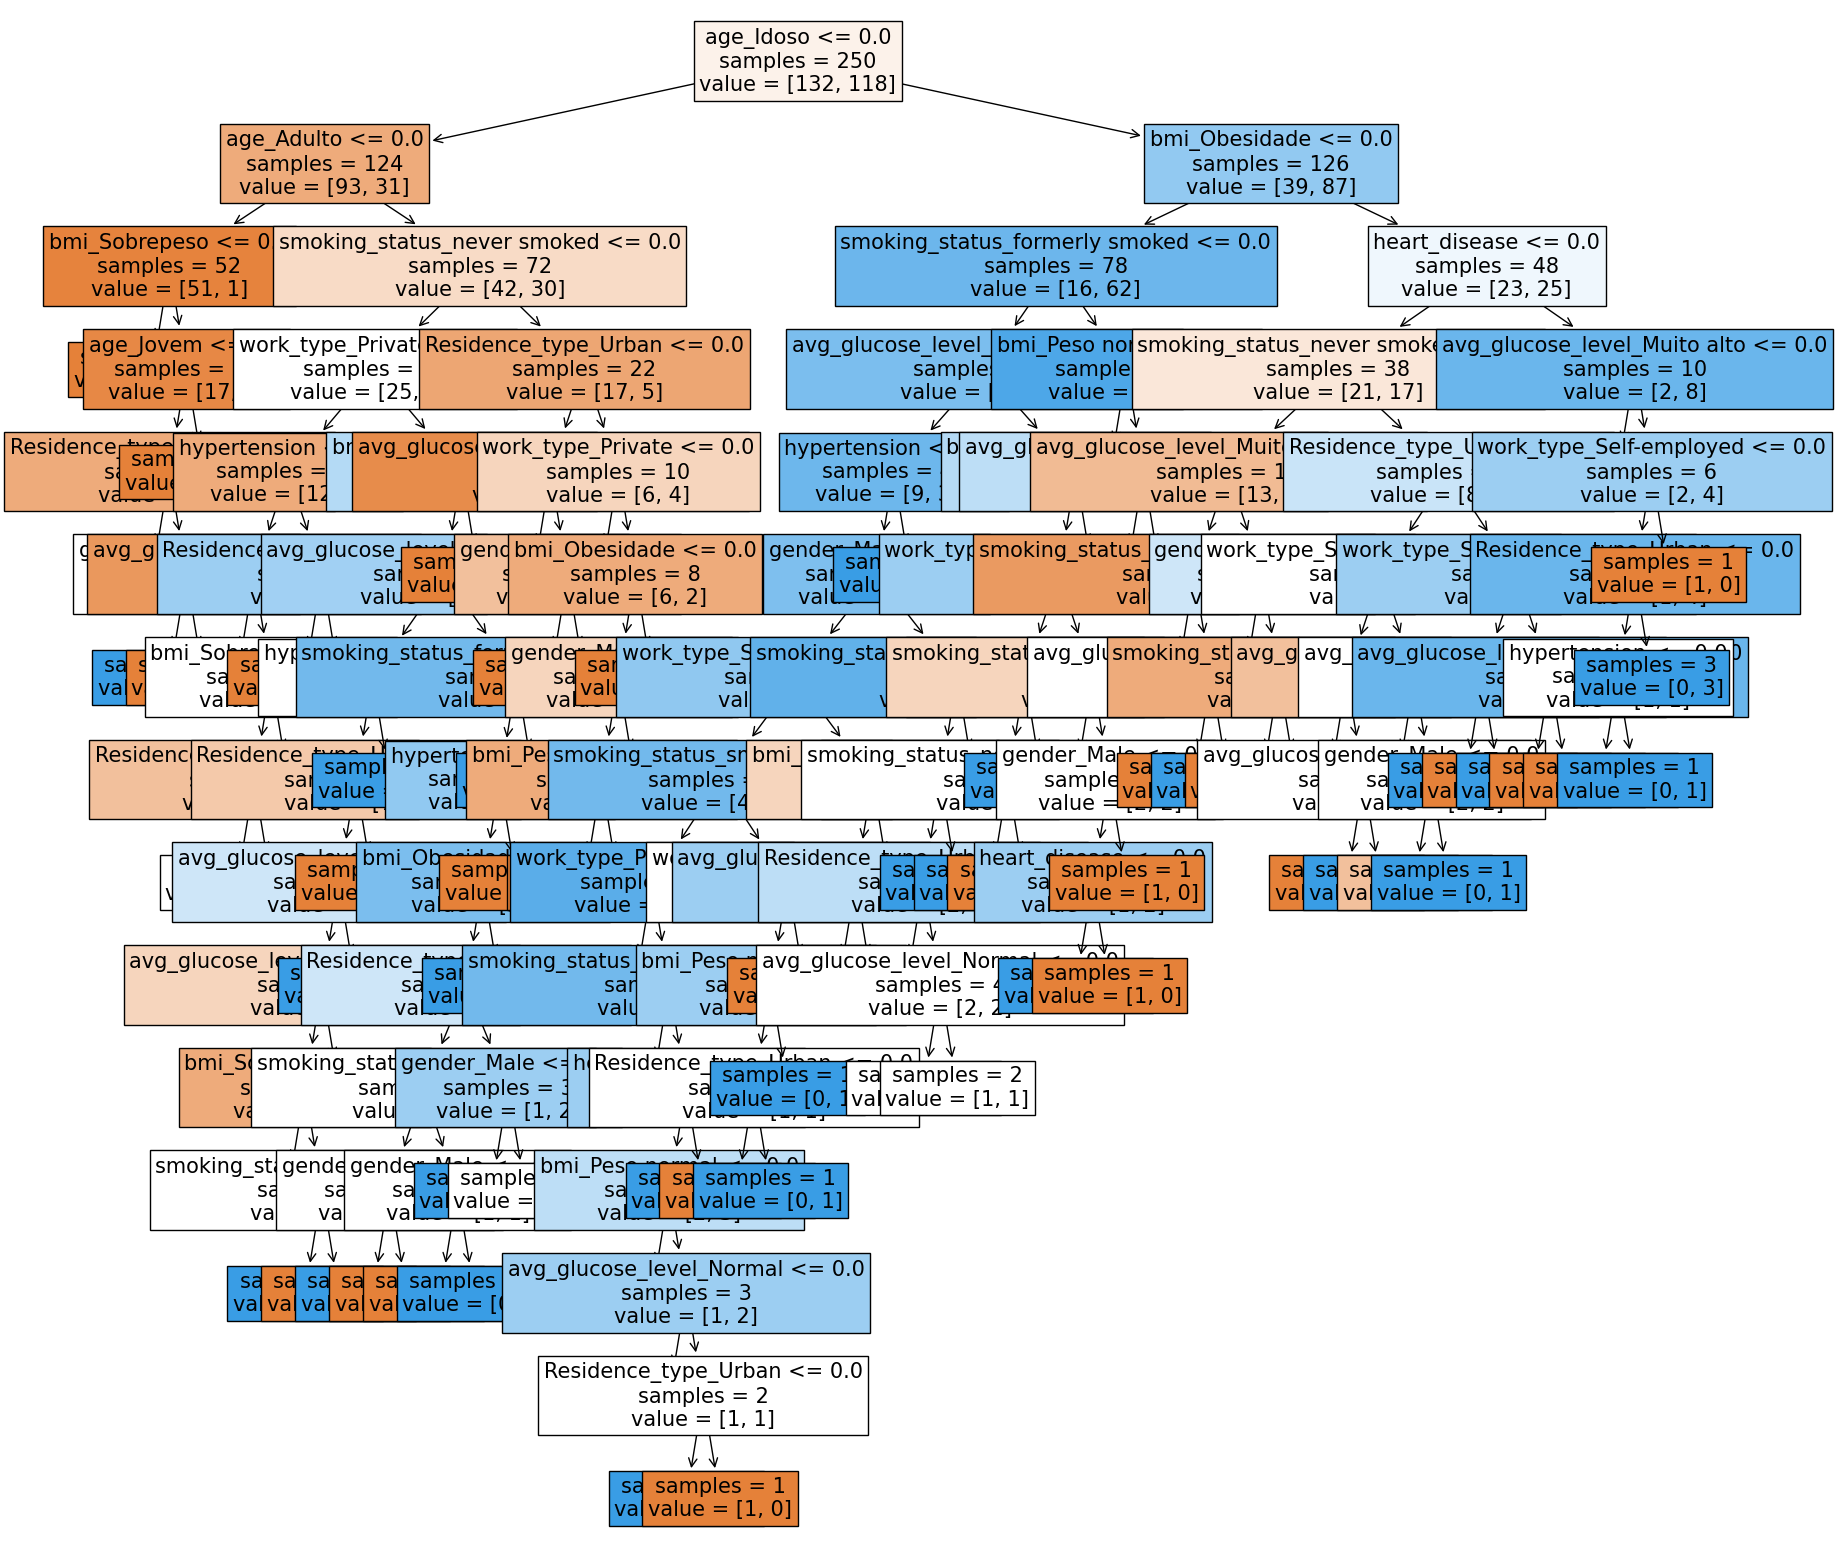

In [175]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy')

# Agora, vamos usar o método .fit() para ajustar os parâmetros da árvore:
tree.fit(X_train, Y_train)

# Podemos visualizar a árvore de decisão em uma figura!
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

In [176]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Acurácia do modelo de árvore de decisão:", accuracy)


Acurácia do modelo de árvore de decisão: 0.616


In [177]:
import pandas as pd

# Obter importância das características
feature_importances = tree.feature_importances_

# Criar DataFrame com as features e sua importância
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar o DataFrame pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Exibir o DataFrame
print(feature_importance_df)


                           Feature  Importance
21                       age_Idoso    0.157644
20                      age_Adulto    0.099353
13        avg_glucose_level_Normal    0.085947
9             Residence_type_Urban    0.076273
2                      gender_Male    0.068730
0                     hypertension    0.060255
15    avg_glucose_level_Muito alto    0.054826
18                   bmi_Obesidade    0.051603
16                 bmi_Peso normal    0.049039
11     smoking_status_never smoked    0.047755
6                work_type_Private    0.044478
1                    heart_disease    0.044269
14          avg_glucose_level_Alto    0.035087
10  smoking_status_formerly smoked    0.034595
7          work_type_Self-employed    0.032961
17                   bmi_Sobrepeso    0.026649
12           smoking_status_smokes    0.020450
19                       age_Jovem    0.010086
8               work_type_children    0.000000
5           work_type_Never_worked    0.000000
4            